In [1]:
import numpy as np
from numpy import load
import matplotlib.pyplot as plt

import requests, gzip, os, hashlib

np.random.seed(42)

In [47]:
mnist_data = dict(load('data/mnist.npz'))
trlen = mnist_data['y_train'].shape[0]
testlen = mnist_data['y_test'].shape[0]

tds = int(testlen*0.5)

Xtr = mnist_data['x_train'].reshape(60000, -1).T
Ytr = mnist_data['y_train'].reshape(-1, 1).T
Xdev = mnist_data['x_test'].reshape(10000, -1).T[:, :tds]
Ydev = mnist_data['y_test'].reshape(-1, 1).T[:, :tds]
Xtest = mnist_data['x_test'].reshape(10000, -1).T[:, tds:]
Ytest = mnist_data['y_test'].reshape(-1, 1).T[:, tds:]
Xtr.shape, Ytr.shape, Xdev.shape, Ydev.shape, Xtest.shape, Ytest.shape

((784, 60000), (1, 60000), (784, 5000), (1, 5000), (784, 5000), (1, 5000))

In [72]:
#def softmax(z: np.ndarray): return np.exp(z)/np.sum(np.exp(z))
def onehot(x: int):
    z = np.zeros((10, 1))
    z[x] = 1
    return z
def softmax(x: np.ndarray):
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)
def relu(x: np.ndarray): return np.maximum(0, x)
def d_relu(x: np.ndarray): return (x>0)*1
    
def loss(yh: np.ndarray, y: int) -> float:
    yh = np.clip(yh, 1e-12, 1-1e-12)
    return -np.log(yh[y])
def cost(yh: np.ndarray, y: np.ndarray) -> float:
    m, tot_loss = len(y), 0
    for i in range(m): tot_loss += loss(yh[i], y[i])
    return tot_loss/m

In [73]:
def accuracy(yh: np.ndarray, y: np.ndarray):
    m = len(y)
    t = 0
    for i in range(m):
        if yh[i] == y[i]: t += 1
    return t/m

In [74]:
class Model:
    def __init__(self, n_in: int, n_hidden: int, n_out: int):
        self.W1 = np.random.randn(n_hidden, n_in) * (2/n_in)**0.5
        self.b1 = np.zeros((n_hidden, 1))
        # add a dropout maybe
        self.a1 = relu
        self.W2 = np.random.randn(n_out, n_hidden) * (2/n_hidden)**0.5
        self.b2 = np.zeros((n_out, 1))
        self.a2 = softmax

    def forward(self, x: np.ndarray):
        l1 = self.a1(np.dot(self.W1, x) + self.b1)
        l2 = self.a2(np.dot(self.W2, l1) + self.b2)
        return l2

    def backward(self, x: np.ndarray, yh: np.ndarray, y: np.ndarray):
        # gradient descent
        m = x.shape[1]
        z1 = np.dot(self.W1, x) + self.b1
        a1 = self.a1(z1)

        dz2 = yh - onehot(y)
        self.dW2 = 1/m*np.dot(dz2, a1.T)
        self.db2 = 1/m*np.sum(dz2, axis=1, keepdims=True)

        dz1 = np.dot(self.W2.T, dz2) * d_relu(z1)
        self.dW1 = 1/m*np.dot(dz1, x.T)
        self.db1 = 1/m*np.sum(dz1, axis=1, keepdims=True)

    def step(self, lr: float):
        self.W1 += -lr*self.dW1
        self.W2 += -lr*self.dW2
        self.b1 += -lr*self.db1
        self.b2 += -lr*self.db2

In [106]:
m = Model(784, 128, 10)
epochs = 10000
iepoch = 500
batch_size = 32
lossi = []

In [107]:
for epoch in range(epochs):    
    ix = np.random.randint(0, Xtr.shape[1], (batch_size,))
    Xba, Yba = Xtr[:, ix], Ytr[:, ix]
    for Xb, Yb in zip(Xba.T, Yba.T): 
        Xb = Xb.reshape(-1, 1)
        
        yh = m.forward(Xb)
        c = loss(yh, Yb.item())
    
        m.backward(Xb, yh, Yb)
        m.step(0.01)
        
    if epoch % iepoch == 0: 
        print(f'{epoch}: loss {c.item():.4f}')
    lossi.append(c.item())

0: loss 2.2933
500: loss 2.3708
1000: loss 2.3547
1500: loss 2.4849
2000: loss 2.3863
2500: loss 2.3101
3000: loss 2.3004
3500: loss 2.0835
4000: loss 2.3157
4500: loss 2.3941
5000: loss 2.2365
5500: loss 2.3191
6000: loss 2.2560
6500: loss 2.2755
7000: loss 2.4191
7500: loss 2.3161
8000: loss 2.3357
8500: loss 2.4288
9000: loss 2.2772
9500: loss 2.3060


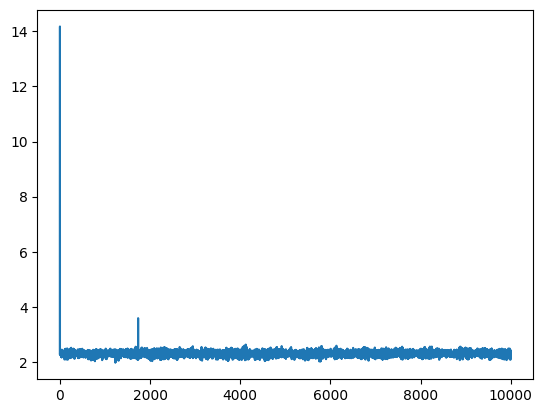

In [108]:
plt.plot(lossi);

In [104]:
yhs = []
mi = Xdev.shape[1]
for i in range(mi):
    Xb = Xdev[:, i].reshape(-1, 1)
    iyh = m.forward(Xb)
    yhs.append(np.argmax(iyh))

In [105]:
devprob = accuracy(yhs, Ydev.T)*100
print(f'acc: {devprob:.2f}%')

acc: 10.40%
